In [1]:
import pandas as pd
import scipy
#import fastcluster
import matplotlib.pyplot as plt
import seaborn as sns
import CococoNet_reader
import Go_annotations

In [2]:
tom_arabi_one_diag = pd.read_csv('/data/passala/Generated_Tables/Temp_junk/topological_overlap_matrix_soothsayer_diagnol_is_one.csv', index_col = 0)
tom_arabi_one_diag

,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,AT1G01110,...,ATCG01070,ATCG01080,ATCG01090,ATCG01100,ATCG01110,ATCG01120,ATCG01130,ATCG01180,ATCG01210,ATCG01310
AT1G01020,1.000000,0.415191,0.470093,0.549461,0.103992,0.416865,0.363423,0.455111,0.519878,0.457421,...,0.004250,0.010740,0.013991,0.039823,0.037015,0.028887,0.203943,0.000895,0.000531,0.018409
AT1G01030,0.415191,1.000000,0.441420,0.465693,0.047168,0.041475,0.383733,0.487935,0.358083,0.113627,...,0.004130,0.007134,0.008097,0.017653,0.013709,0.010200,0.044914,0.001036,0.000731,0.010614
AT1G01040,0.470093,0.441420,1.000000,0.513526,0.191991,0.488724,0.282637,0.431355,0.361973,0.440798,...,0.003599,0.009994,0.010667,0.045596,0.038390,0.019875,0.120736,0.000422,0.000229,0.009773
AT1G01050,0.549461,0.465693,0.513526,1.000000,0.263658,0.516329,0.441080,0.526882,0.559990,0.493590,...,0.003701,0.013895,0.017298,0.056801,0.042870,0.028224,0.236971,0.000703,0.000361,0.030917
AT1G01060,0.103992,0.047168,0.191991,0.263658,1.000000,0.032092,0.204347,0.189283,0.080196,0.014298,...,0.000432,0.001135,0.000948,0.004317,0.001819,0.000609,0.004235,0.000054,0.000021,0.001273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCG01120,0.028887,0.010200,0.019875,0.028224,0.000609,0.001148,0.066645,0.045688,0.027991,0.006810,...,0.539777,0.684300,0.630428,0.747186,0.654135,1.000000,0.623805,0.209762,0.179000,0.174155
ATCG01130,0.203943,0.044914,0.120736,0.236971,0.004235,0.006899,0.364604,0.290217,0.255005,0.043772,...,0.523796,0.518207,0.532894,0.465616,0.529607,0.623805,1.000000,0.300150,0.255670,0.271724
ATCG01180,0.000895,0.001036,0.000422,0.000703,0.000054,0.000027,0.009703,0.002788,0.000310,0.000032,...,0.528660,0.617143,0.534663,0.635058,0.477973,0.209762,0.300150,1.000000,0.533756,0.118017
ATCG01210,0.000531,0.000731,0.000229,0.000361,0.000021,0.000023,0.007158,0.001852,0.000144,0.000020,...,0.498405,0.578446,0.497651,0.591585,0.436738,0.179000,0.255670,0.533756,1.000000,0.092876


In [3]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck


def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype(float)
    np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)


def _runNV(go, nw, nFold=3, min_count=20, max_count=1000):

    #Make sure genes are same in go and nw
    genes_intersect = go.index.intersection(nw.index)

    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]

    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns)


def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()
        
    CVgo = np.concatenate(list(cvgo.values()), axis=1)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)

    predicts = sumin / degree[:, None]

    np.place(predicts, CVgo > 0, np.nan)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan

    filtering = np.tile(go, nFold)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)

    #Number of predictions
    #Number of 1's masked for each GO term for each CV
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn

    return roc, avg_degree, roc_null, P


In [4]:
#hier_cluster_arabi = fastcluster.linkage(tom_arabi_one_diag,method = 'average')

In [5]:
import pickle 

In [6]:
# with open('/data/passala/Generated_Tables/Temp_junk/hier_cluster_of_tom_arabi.p', 'wb') as file:
      
#     # A new file will be created
#     pickle.dump(hier_cluster_arabi, file)

In [7]:
#pickleFile = open("/data/passala/Generated_Tables/Temp_junk/hier_cluster_of_tom_arabi.p","rb")

In [8]:
hier_cluster_arabi = pickle.load(open("/data/passala/Generated_Tables/Temp_junk/hier_cluster_of_tom_arabi.p", "rb"))

In [9]:
labels = pickle.load(open("/data/passala/Generated_Tables/Temp_junk/distance_6_labels_for_heir_cluster.p", "rb"))

In [10]:
hier_cluster_arabi

array([[2.08640000e+04, 2.08710000e+04, 5.85137595e-01, 2.00000000e+00],
       [2.08110000e+04, 2.08490000e+04, 6.08153659e-01, 2.00000000e+00],
       [2.08480000e+04, 2.08680000e+04, 6.67683411e-01, 2.00000000e+00],
       ...,
       [4.17460000e+04, 4.17510000e+04, 2.54058048e+01, 8.70000000e+03],
       [4.17520000e+04, 4.17530000e+04, 3.08775062e+01, 1.21790000e+04],
       [4.17540000e+04, 4.17550000e+04, 3.88732053e+01, 2.08790000e+04]])

In [11]:
# plt.figure(figsize=(30, 10))  
# plt.title("Dendrograms")  
# dend = scipy.cluster.hierarchy.dendrogram(hier_cluster_arabi)

In [12]:
import numpy as np
from matplotlib.path import Path
from matplotlib.collections import LineCollection

In [13]:
# fig = plt.figure(figsize=(30, 10))
# ax = fig.add_subplot(1,1,1)

# scipy.cluster.hierarchy.dendrogram(hier_cluster_arabi, ax=ax);

# for c in ax.collections[:]: # use [:] to get a copy, since we're adding to the same list
#     paths = []
#     for path in c.get_paths():
#         segments = []
#         y_at_x = {}
#         # Pre-pass over all elements, to find the lowest y value at each x value.
#         # we can use this to caculate where to cut our lines.
#         for n, seg in enumerate(path.iter_segments()):
#             x, y = seg[0]
#             # Don't store if the y is zero, or if it's higher than the current low.
#             if y > 0 and y < y_at_x.get(x, np.inf):
#                 y_at_x[x] = y

#         for n, seg in enumerate(path.iter_segments()):
#             x, y = seg[0]

#             if y == 0:
#                 # If we know the last y at this x, use it - 0.5, limit > 0
#                 y = max(0, y_at_x.get(x, 0) - 0.5)

#             segments.append([x,y])

#         paths.append(segments)

#     lc = LineCollection(paths, colors=c.get_colors())  # Recreate a LineCollection with the same params
#     ax.add_collection(lc)
#     ax.collections.remove(c) # Remove the original LineCollection


In [14]:
# labels = scipy.cluster.hierarchy.fcluster(hier_cluster_arabi, 6, criterion= 'distance')

In [15]:
len(labels)

20879

In [16]:
labels.max()

1357

In [17]:
label_df = pd.DataFrame(index = tom_arabi_one_diag.index, columns = ['Cluster'], data = labels)
label_df

,Cluster
AT1G01020,448
AT1G01030,1344
AT1G01040,40
AT1G01050,199
AT1G01060,617
...,...
ATCG01120,522
ATCG01130,613
ATCG01180,522
ATCG01210,522


In [18]:
label_df['Present'] = 1
label_df

,Cluster,Present
AT1G01020,448,1
AT1G01030,1344,1
AT1G01040,40,1
AT1G01050,199,1
AT1G01060,617,1
...,...,...
ATCG01120,522,1
ATCG01130,613,1
ATCG01180,522,1
ATCG01210,522,1


In [19]:
def get_fc_sc_btw_two_species_with_gene_list_custom_arabi(species_1,species_2,list_of_genes_in_species_1_as_panda):
    import pandas as pd
    import numpy as np
    #Convert Taxa to common names if NCBI taxa ID
    #Set up variable 
    fc_mapper = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/Species_name_resolver.csv')

    if type(species_1) == int:
        species_1 = fc_mapper['Common Name'].loc[fc_mapper['Taxa ID'] == species_1].item()
    if type(species_2) == int:
        species_2 = fc_mapper['Common Name'].loc[fc_mapper['Taxa ID'] == species_2].item()

    #Convert scientific name to common names if given scientific
    if ' ' in species_1:
        species_1 = fc_mapper['Common Name'].loc[fc_mapper['Species'] == species_1].item()
    if ' ' in species_2:
        species_2 = fc_mapper['Common Name'].loc[fc_mapper['Species'] == species_2].item()

    #Get Scientific Name
    scientific_1 = fc_mapper['Species'].loc[fc_mapper['Common Name'] == species_1].item()
    scientific_2 = fc_mapper['Species'].loc[fc_mapper['Common Name'] == species_2].item()

    if species_1 == species_2:
        raise NameError("Species are the Same, submit different species")
    
    # Get Path for Orthologs
    path_to_orthologs_mapped_pd = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/mapping_paths_for_fc_scores.csv',index_col = 0)
    path_to_orthologs = path_to_orthologs_mapped_pd.loc[scientific_1,scientific_2]

    ortholog_map = pd.read_csv(path_to_orthologs)
    file_name = path_to_orthologs.split('/')[-1]
    file_name = file_name.split('_')
    if file_name[0] == species_1:
        list_of_genes_in_species_1_as_panda = list_of_genes_in_species_1_as_panda.rename(columns = {list_of_genes_in_species_1_as_panda.columns[0]:'Arabi'})
        fc_sc_map = list_of_genes_in_species_1_as_panda.merge(ortholog_map,left_on = 'Arabi',right_on = 'sp1_gene',how = 'left')
        fc_sc_map.dropna(inplace = True)
    if file_name[1] == species_1:
        list_of_genes_in_species_1_as_panda = list_of_genes_in_species_1_as_panda.rename(columns = {list_of_genes_in_species_1_as_panda.columns[0]:'Arabi'})
        fc_sc_map = list_of_genes_in_species_1_as_panda.merge(ortholog_map,left_on = 'Arabi', right_on = 'sp2_gene',how = 'left')
        fc_sc_map.dropna(inplace = True)
    # return fc_sc_map,species_name
    return fc_sc_map

In [20]:
wide_label = label_df.pivot(columns= 'Cluster',values = 'Present')

In [21]:
wide_label = wide_label.replace(np.nan,0)
wide_label

Cluster,1,2,3,4,5,6,7,8,9,10,...,1348,1349,1350,1351,1352,1353,1354,1355,1356,1357
AT1G01020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSRNA049495549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNA049495550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNA049495561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNA049495564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
(wide_label.sum()>10).sum()

614

In [23]:
wide_label.sum().max()

152.0

In [24]:
large_enough_clusters = wide_label.loc[:,wide_label.sum()>10]
large_enough_clusters.columns = 'Cluster ' + large_enough_clusters.columns.astype(str)
large_enough_clusters

Cluster,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,...,Cluster 1336,Cluster 1337,Cluster 1341,Cluster 1343,Cluster 1344,Cluster 1345,Cluster 1346,Cluster 1347,Cluster 1348,Cluster 1349
AT1G01020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
AT1G01040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSRNA049495549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNA049495550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNA049495561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNA049495564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
list_of_clusters = large_enough_clusters.columns
list_of_clusters

Index(['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5',
       'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10',
       ...
       'Cluster 1336', 'Cluster 1337', 'Cluster 1341', 'Cluster 1343',
       'Cluster 1344', 'Cluster 1345', 'Cluster 1346', 'Cluster 1347',
       'Cluster 1348', 'Cluster 1349'],
      dtype='object', name='Cluster', length=614)

In [26]:
non_arab_species = ['grape','soybean','medicago','tomato','potato','rice','brome','sorghum','maize']

In [27]:
# egad_results = pd.DataFrame(index = list_of_clusters)
# fc_results = pd.DataFrame(index = list_of_clusters)
# for species in ['grape','soybean','medicago','tomato','potato','rice','brome','sorghum','maize']:
#     print(species)
#     current_species_cococonet = CococoNet_reader.read_cococonet(species)
#     fc_averages_for_current_species = []
#     current_egad_gene_list = pd.DataFrame(columns = list_of_clusters, index = current_species_cococonet.index)
#     for cluster in list_of_clusters:
#         current_genes = large_enough_clusters.loc[large_enough_clusters[cluster] == 1]
#         formatted_df_for_function = pd.DataFrame(index = current_genes.index)
#         formatted_df_for_function['Gene'] = formatted_df_for_function.index
#         formatted_df_for_function = formatted_df_for_function.reset_index(drop= True)

#         fc_scores = get_fc_sc_btw_two_species_with_gene_list_custom_arabi('arabidopsis',species,formatted_df_for_function)
#         avg_score = fc_scores['fc'].mean()
#         fc_averages_for_current_species.append(avg_score)
#         if len(fc_scores.loc[fc_scores['sp1_gene'].str.contains('AT')]) > 1: 
#             genes = fc_scores['sp2_gene'].values
#             current_egad_gene_list[cluster][genes] = 1
#         elif len(fc_scores.loc[fc_scores['sp1_gene'].str.contains('AT')]) == 1:
#             continue
        
#         else:
#             genes = fc_scores['sp1_gene'].values
#             current_egad_gene_list[cluster][genes] = 1 
#     current_egad_gene_list = current_egad_gene_list.replace(np.nan, 0)
#     current_egad_results = run_egad(go = current_egad_gene_list, nw = current_species_cococonet, min_count=10 )
#     egad_results = egad_results.merge(how = 'left',left_index= True, right_index= True, right = current_egad_results[['AUC']])
#     egad_results = egad_results.rename(columns = {'AUC':f'{species} AUC'})
#     fc_results[species] = fc_averages_for_current_species

        

        

    

In [28]:
#fc_results.to_csv('/data/passala/Generated_Tables/Comparing_all_go_groups_across_species/fc_results_from_wcgna_clusters_arabi.csv')
#egad_results.to_csv('/data/passala/Generated_Tables/Comparing_all_go_groups_across_species/egad_results_from_wcgna_clusters_arabi.csv')

In [29]:
fc_results = pd.read_csv('/data/passala/Generated_Tables/Comparing_all_go_groups_across_species/fc_results_from_wcgna_clusters_arabi.csv', index_col= 0)

egad_results = pd.read_csv('/data/passala/Generated_Tables/Comparing_all_go_groups_across_species/egad_results_from_wcgna_clusters_arabi.csv', index_col= 0)

In [30]:
fc_results['Mean'] = fc_results.mean(axis = 1)
fc_results

,grape,soybean,medicago,tomato,potato,rice,brome,sorghum,maize,Mean
Cluster,,,,,,,,,,
Cluster 1,0.804571,0.786708,0.789561,0.804909,0.802383,0.736102,0.768145,0.794343,0.779935,0.785184
Cluster 2,0.779765,0.732449,0.787050,0.794339,0.771072,0.694779,0.750996,0.787680,0.776539,0.763852
Cluster 3,0.803452,0.779666,0.814386,0.828315,0.790199,0.745802,0.794761,0.819290,0.820368,0.799582
Cluster 4,0.800339,0.764559,0.806652,0.790022,0.783578,0.721486,0.765365,0.794797,0.778097,0.778322
Cluster 5,0.811670,0.792713,0.824504,0.844845,0.807680,0.739694,0.807808,0.817512,0.788091,0.803835
...,...,...,...,...,...,...,...,...,...,...
Cluster 1345,0.606848,0.566182,0.569489,0.583867,0.530991,0.468970,0.448908,0.481133,0.549045,0.533937
Cluster 1346,0.579323,0.598577,0.558249,0.558712,0.433536,0.553467,0.535378,0.544712,0.588065,0.550002
Cluster 1347,0.603671,0.519631,0.657763,0.636872,0.634536,NaN,0.579118,0.619139,0.594779,0.605689


In [31]:
egad_results['Mean'] = egad_results.mean(axis = 1)

In [32]:
plotted_groups = pd.DataFrame(index = egad_results.index)
plotted_groups['Avg EGAD'] = egad_results['Mean']
plotted_groups['Avg FC'] = fc_results['Mean']
plotted_groups

,Avg EGAD,Avg FC
Cluster,,
Cluster 1,0.628472,0.785184
Cluster 2,0.653675,0.763852
Cluster 3,0.651166,0.799582
Cluster 4,0.586362,0.778322
Cluster 5,0.681020,0.803835
...,...,...
Cluster 1345,NaN,0.533937
Cluster 1346,0.637351,0.550002
Cluster 1347,0.605707,0.605689


In [33]:
plotted_groups = plotted_groups.dropna()
plotted_groups

,Avg EGAD,Avg FC
Cluster,,
Cluster 1,0.628472,0.785184
Cluster 2,0.653675,0.763852
Cluster 3,0.651166,0.799582
Cluster 4,0.586362,0.778322
Cluster 5,0.681020,0.803835
...,...,...
Cluster 1344,0.739845,0.565405
Cluster 1346,0.637351,0.550002
Cluster 1347,0.605707,0.605689


No handles with labels found to put in legend.


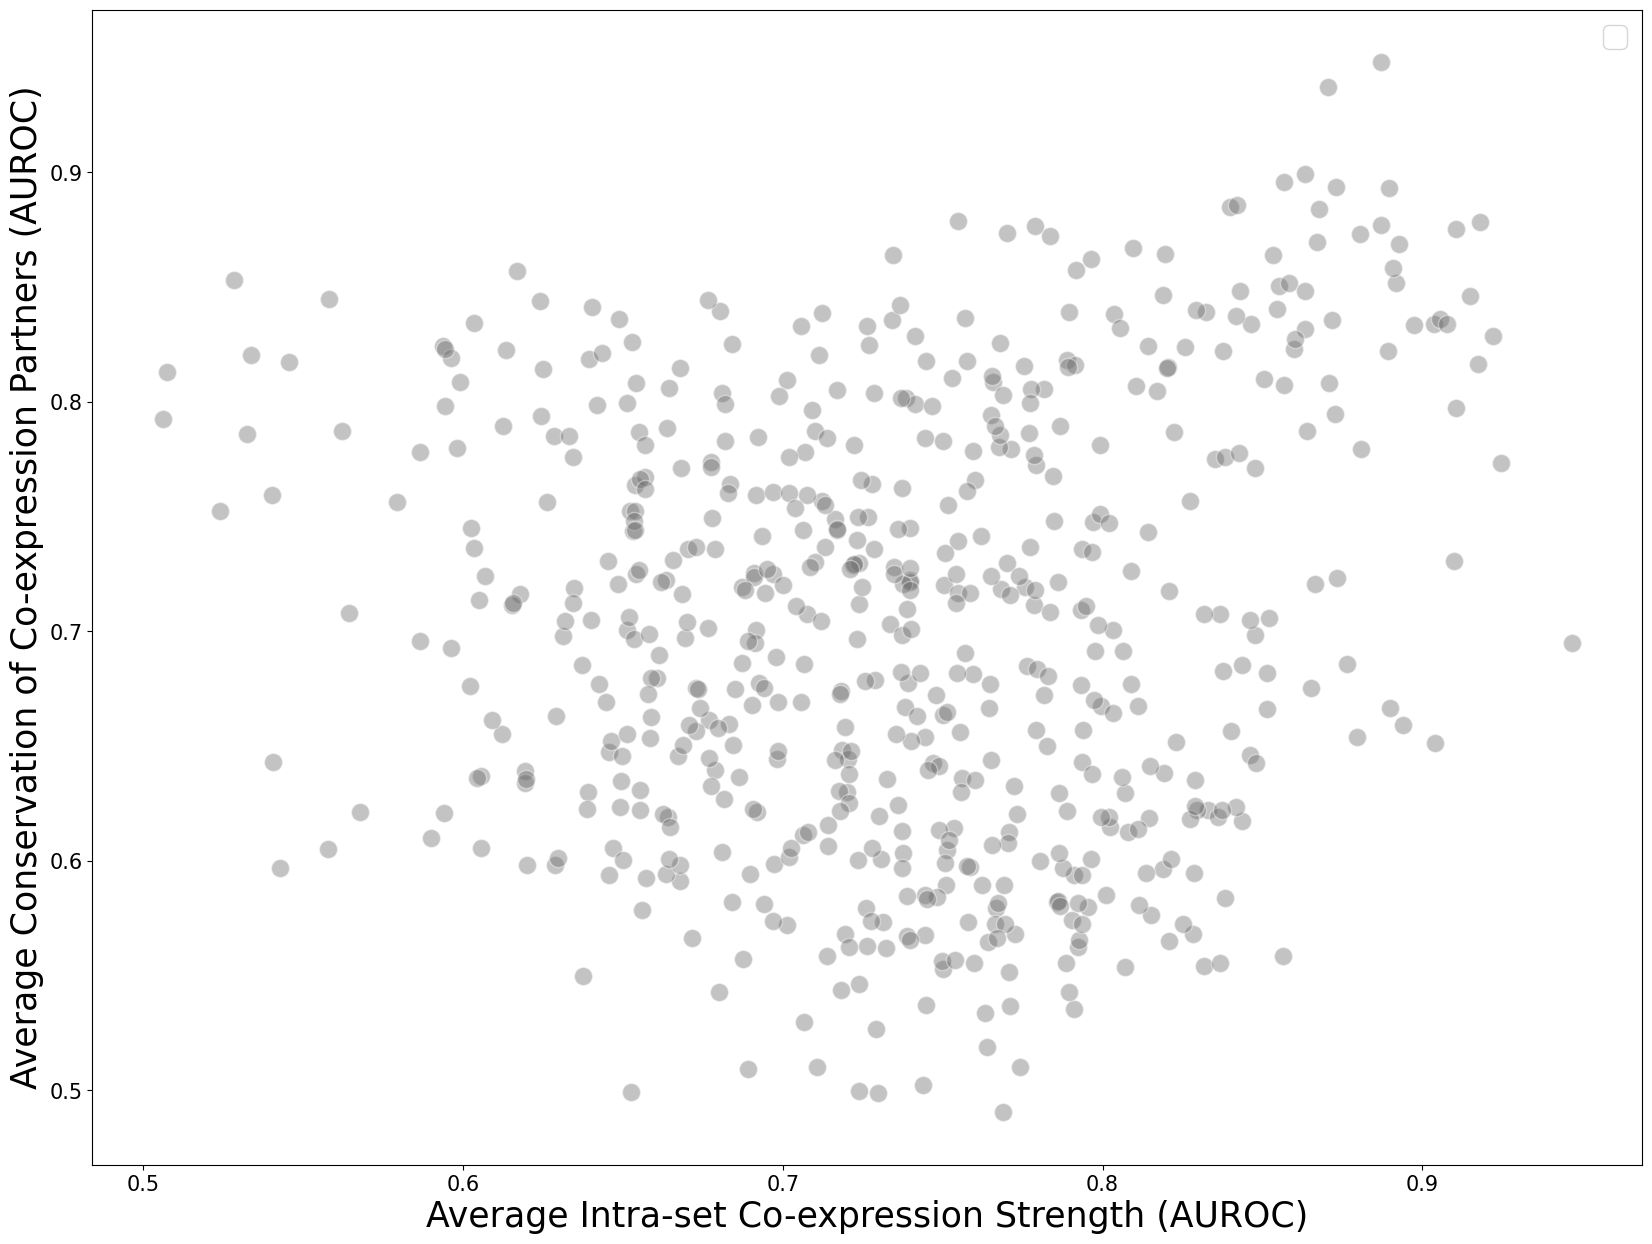

In [34]:
fig, ax = plt.subplots(figsize = (20,15))
sns.scatterplot(data = plotted_groups,y = 'Avg FC',x = 'Avg EGAD',s = 170,color = 'dimgray', alpha = .4 )

plt.ylabel("Average Conservation of Co-expression Partners (AUROC)", fontsize = 25)
plt.xlabel("Average Intra-set Co-expression Strength (AUROC)", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize= 22,markerscale = 2.5)
#plt.savefig('/data/passala/Plots_for_projects/Cross_species_go_groups/WCGNA_comparison/wcgna_of_groups_from_arabidopsis.jpg',dpi = 800)

In [33]:
full_annotated_group_list = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/all_annotated_go_groups.csv',encoding = 'cp1252',index_col= 0)
full_annotated_group_list

,Avg FC,Avg EGAD,Name,EGAD Counts,Annotation,Notes
GO:0000003,0.740324,0.634227,reproduction,10,None,NaN
GO:0000018,0.766573,0.798689,regulation of DNA recombination,8,None,NaN
GO:0000027,0.923946,0.869159,ribosomal large subunit assembly,9,Ribosomal,NaN
GO:0000028,0.951180,0.875073,ribosomal small subunit assembly,9,Ribosomal,NaN
GO:0000030,0.714718,0.642678,mannosyltransferase activity,8,None,Critical function in eukaryotes
...,...,...,...,...,...,...
GO:2001020,0.821085,0.761272,regulation of response to DNA damage stimulus,9,None,NaN
GO:2001070,0.720227,0.869219,starch binding,7,None,NaN
GO:2001141,0.722697,0.673483,regulation of RNA biosynthetic process,6,None,NaN
GO:2001251,0.778751,0.805120,negative regulation of chromosome organization,9,None,NaN


In [34]:
full_annotated_group_list['Type'] = 'Go Group'
plotted_groups['Type'] = 'WGCNA Group'


/home/passala/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
plotted_groups

,Avg EGAD,Avg FC,Type
Cluster,,,
Cluster 1,0.628472,0.785184,WGCNA Group
Cluster 2,0.653675,0.763852,WGCNA Group
Cluster 3,0.651166,0.799582,WGCNA Group
Cluster 4,0.586362,0.778322,WGCNA Group
Cluster 5,0.681020,0.803835,WGCNA Group
...,...,...,...
Cluster 1344,0.739845,0.565405,WGCNA Group
Cluster 1346,0.637351,0.550002,WGCNA Group
Cluster 1347,0.605707,0.605689,WGCNA Group


In [36]:
merged_go_wcgna = pd.concat([full_annotated_group_list[['Avg FC','Avg EGAD','Type']],plotted_groups])

In [37]:
merged_go_wcgna

,Avg FC,Avg EGAD,Type
GO:0000003,0.740324,0.634227,Go Group
GO:0000018,0.766573,0.798689,Go Group
GO:0000027,0.923946,0.869159,Go Group
GO:0000028,0.951180,0.875073,Go Group
GO:0000030,0.714718,0.642678,Go Group
...,...,...,...
Cluster 1344,0.565405,0.739845,WGCNA Group
Cluster 1346,0.550002,0.637351,WGCNA Group
Cluster 1347,0.605689,0.605707,WGCNA Group
Cluster 1348,0.667294,0.811109,WGCNA Group


In [38]:
merged_go_wcgna['Type'].value_counts()

Go Group       3011
WGCNA Group     608
Name: Type, dtype: int64

In [39]:
real_modules = merged_go_wcgna.loc[merged_go_wcgna['Avg EGAD']>.75]
real_modules

,Avg FC,Avg EGAD,Type
GO:0000018,0.766573,0.798689,Go Group
GO:0000027,0.923946,0.869159,Go Group
GO:0000028,0.951180,0.875073,Go Group
GO:0000049,0.864284,0.776473,Go Group
GO:0000054,0.813080,0.767277,Go Group
...,...,...,...
Cluster 1335,0.641325,0.814768,WGCNA Group
Cluster 1337,0.666497,0.764501,WGCNA Group
Cluster 1343,0.636332,0.805941,WGCNA Group
Cluster 1348,0.667294,0.811109,WGCNA Group


In [40]:
real_modules['Type'].value_counts()

Go Group       904
WGCNA Group    271
Name: Type, dtype: int64

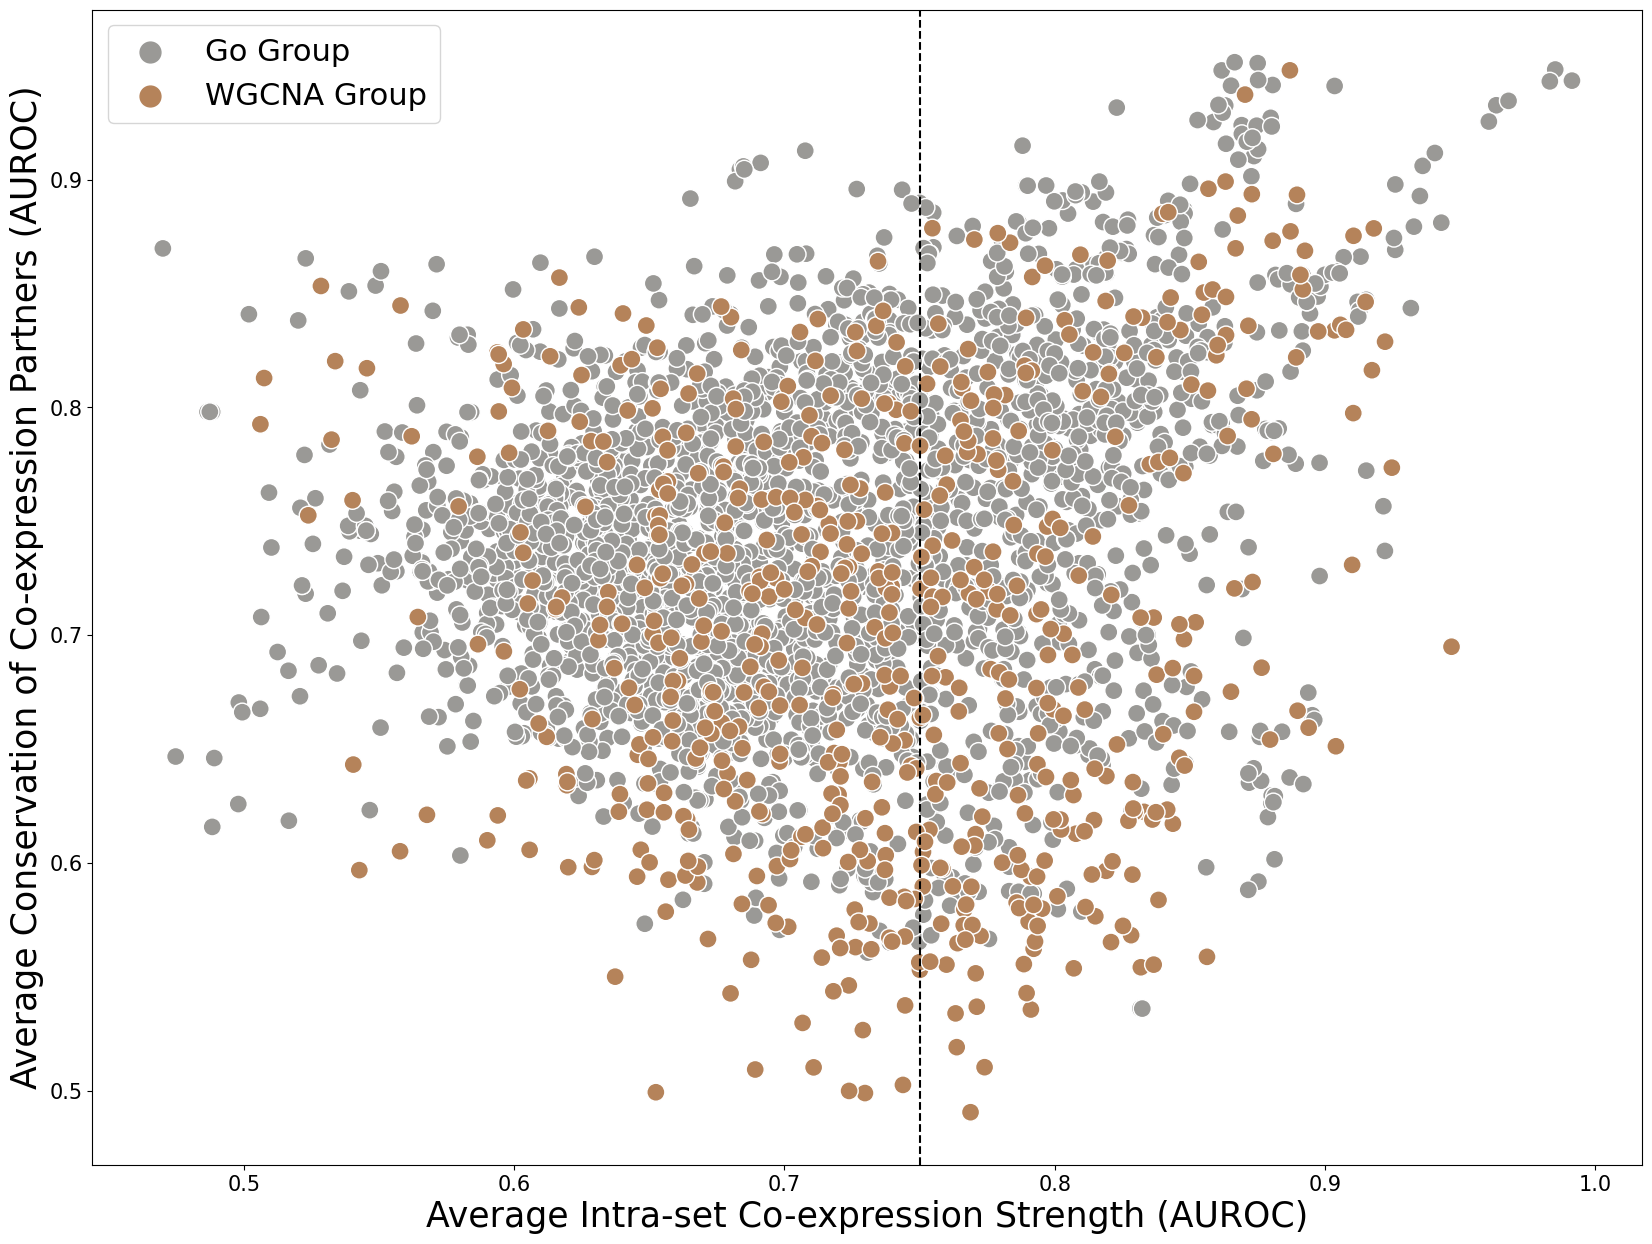

In [45]:
fig, ax = plt.subplots(figsize = (20,15))
sns.scatterplot(data = merged_go_wcgna,y = 'Avg FC',x = 'Avg EGAD',s = 170,hue = 'Type', alpha = 1,  palette = ['#9a9996','#b5835a',], )
plt.axvline(.75, 0,1,color = 'k', linestyle = '--')
plt.ylabel("Average Conservation of Co-expression Partners (AUROC)", fontsize = 25)
plt.xlabel("Average Intra-set Co-expression Strength (AUROC)", fontsize = 25)
#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize= 22,markerscale = 2.5)
#plt.savefig('/data/passala/Plots_for_projects/Cross_species_go_groups/WCGNA_comparison/wcgna_of_groups_from_arabidopsis.jpg',dpi = 800)

In [46]:
arabi_coconet = CococoNet_reader.read_cococonet('arabidopsis')


In [47]:
large_enough_clusters

Cluster,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,...,Cluster 1336,Cluster 1337,Cluster 1341,Cluster 1343,Cluster 1344,Cluster 1345,Cluster 1346,Cluster 1347,Cluster 1348,Cluster 1349
AT1G01020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
AT1G01040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSRNA049495549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNA049495550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNA049495561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNA049495564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
arabi_egad = run_egad(go = large_enough_clusters, nw = arabi_coconet, min_count=10 )


/home/passala/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide


In [37]:
arabi_go = Go_annotations.get_go_annotations_as_panda('arabidopsis')
arabi_go

GO_term,GO:0000002,GO:0000003,GO:0000009,GO:0000012,GO:0000014,GO:0000015,GO:0000018,GO:0000019,GO:0000023,GO:0000024,...,GO:2001251,GO:2001252,GO:2001253,GO:2001257,GO:2001279,GO:2001280,GO:2001289,GO:2001293,GO:2001294,GO:2001295
NetworkIDs,,,,,,,,,,,,,,,,,,,,,
AT1G01010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01030,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01040,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATMG01350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATMG01360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATMG01370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
arabi_go = arabi_go.loc[arabi_go.index.isin(large_enough_clusters.index)]
arabi_go

GO_term,GO:0000002,GO:0000003,GO:0000009,GO:0000012,GO:0000014,GO:0000015,GO:0000018,GO:0000019,GO:0000023,GO:0000024,...,GO:2001251,GO:2001252,GO:2001253,GO:2001257,GO:2001279,GO:2001280,GO:2001289,GO:2001293,GO:2001294,GO:2001295
NetworkIDs,,,,,,,,,,,,,,,,,,,,,
AT1G01020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01030,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01040,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01060,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATMG01330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATMG01350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATMG01360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
slimmed_large_clusters = large_enough_clusters.loc[large_enough_clusters.index.isin(arabi_go.index)]
slimmed_large_clusters

Cluster,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,...,Cluster 1336,Cluster 1337,Cluster 1341,Cluster 1343,Cluster 1344,Cluster 1345,Cluster 1346,Cluster 1347,Cluster 1348,Cluster 1349
AT1G01020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
AT1G01040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AT1G01060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATMG01330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATMG01350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATMG01360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATMG01370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
all(slimmed_large_clusters.index == arabi_go.index)

True

In [41]:
arabi_go_t = arabi_go.T

In [42]:
arabi_go_t

NetworkIDs,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,AT1G01110,...,ATMG01130,ATMG01170,ATMG01200,ATMG01220,ATMG01280,ATMG01330,ATMG01350,ATMG01360,ATMG01370,ATMG01410
GO_term,,,,,,,,,,,,,,,,,,,,,
GO:0000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0000003,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0000009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0000012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:2001280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:2001289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:2001293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
cluster_comparison = arabi_go_t.dot(slimmed_large_clusters)
cluster_comparison

Cluster,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,...,Cluster 1336,Cluster 1337,Cluster 1341,Cluster 1343,Cluster 1344,Cluster 1345,Cluster 1346,Cluster 1347,Cluster 1348,Cluster 1349
GO_term,,,,,,,,,,,,,,,,,,,,,
GO:0000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0000003,6.0,4.0,7.0,5.0,1.0,6.0,3.0,3.0,1.0,1.0,...,2.0,1.0,3.0,4.0,2.0,0.0,0.0,0.0,4.0,6.0
GO:0000009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0000012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:0000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:2001280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:2001289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GO:2001293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
slimmed_large_clusters.sum()

Cluster
Cluster 1       50.0
Cluster 2       73.0
Cluster 3       80.0
Cluster 4       80.0
Cluster 5       13.0
                ... 
Cluster 1345    13.0
Cluster 1346    13.0
Cluster 1347    19.0
Cluster 1348    16.0
Cluster 1349    20.0
Length: 614, dtype: float64

In [54]:
arabi_go_t.sum(axis= 1)

GO_term
GO:0000002       5.0
GO:0000003    1554.0
GO:0000009       3.0
GO:0000012       4.0
GO:0000014      10.0
               ...  
GO:2001280       0.0
GO:2001289       5.0
GO:2001293       7.0
GO:2001294       2.0
GO:2001295       5.0
Length: 10704, dtype: float64

In [55]:
percent_covered = cluster_comparison/arabi_go_t.sum(axis = 1)

In [56]:
percent_covered

,Cluster 1,Cluster 10,Cluster 100,Cluster 1000,Cluster 1002,Cluster 1004,Cluster 1005,Cluster 1006,Cluster 1009,Cluster 1010,...,GO:2001251,GO:2001252,GO:2001253,GO:2001257,GO:2001279,GO:2001280,GO:2001289,GO:2001293,GO:2001294,GO:2001295
GO_term,,,,,,,,,,,,,,,,,,,,,
GO:0000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:0000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:0000009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:0000012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:0000014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:2001280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:2001289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GO:2001293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
percent_covered.max()

Cluster 1      NaN
Cluster 10     NaN
Cluster 100    NaN
Cluster 1000   NaN
Cluster 1002   NaN
                ..
GO:2001280     NaN
GO:2001289     NaN
GO:2001293     NaN
GO:2001294     NaN
GO:2001295     NaN
Length: 11318, dtype: float64

<AxesSubplot:ylabel='Count'>

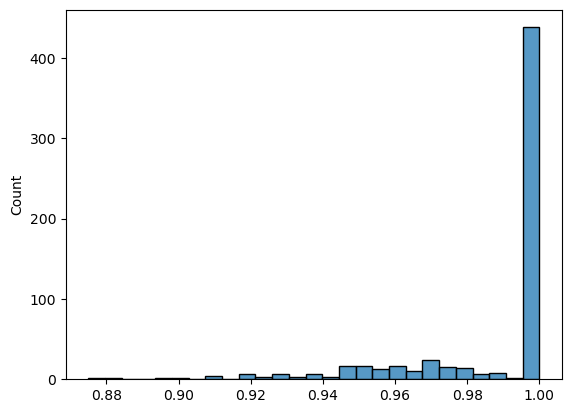

In [50]:
sns.histplot(x = percent_covered.max())

In [66]:
arabi_egad.median()

AUC                9.018684e-01
AVG_NODE_DEGREE    1.158321e+04
DEGREE_NULL_AUC    5.181537e-01
P_Value            2.885701e-09
dtype: float64

<AxesSubplot:xlabel='AUC', ylabel='Count'>

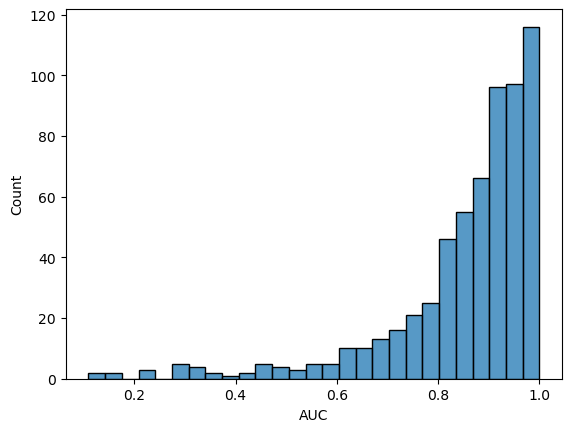

In [65]:
sns.histplot(x = arabi_egad['AUC'])

In [63]:
arabi_egad.sort_values(by = 'AUC',ascending= False)[500:520]

,AUC,AVG_NODE_DEGREE,DEGREE_NULL_AUC,P_Value
Cluster,,,,
Cluster 278,0.770041,12934.587940,0.681285,3.047009e-06
Cluster 166,0.767367,14048.331173,0.844730,1.784037e-03
Cluster 390,0.764882,13488.134478,0.760056,8.791132e-04
Cluster 497,0.764529,13742.375110,0.798156,2.002832e-03
Cluster 496,0.763788,13558.486782,0.770654,1.775775e-03
Cluster 448,0.759482,13959.240359,0.831023,4.637553e-04
Cluster 465,0.757879,13863.605119,0.817222,3.059592e-06
Cluster 30,0.757847,13587.038222,0.775052,1.058005e-03
Cluster 459,0.757624,13522.109217,0.765252,2.221922e-05


In [59]:
arabi_egad.sort_values(by = 'AUC',ascending= False).head(50)

SyntaxError: invalid syntax (2154043298.py, line 1)

In [202]:
current_egad_gene_list = pd.DataFrame(columns = list_of_clusters, index = current_species_cococonet.index)


In [214]:
test_genes

['LOC100249384',
 'LOC100258246',
 'LOC100260314',
 'LOC100256545',
 'LOC100262456',
 'LOC100241124',
 'LOC100247876',
 'LOC100265711',
 'LOC100251814',
 'LOC100248309',
 'LOC100255322',
 'LOC100266606',
 'LOC100262332',
 'LOC100267491',
 'LOC100263583',
 'LOC100267671',
 'LOC100244871',
 'LOC100255920',
 'LOC100259892',
 'LOC100263596',
 'LOC100265798']

In [215]:
current_egad_gene_list

Cluster,1,2,3,4,5,6,7,8,9,10,...,1336,1337,1341,1343,1344,1345,1346,1347,1348,1349
LOC104879287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LOC100259472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LOC100257674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LOC104879282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LOC100254292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ViviCt006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ViviCt010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ViviCt014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ViviCt019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [218]:
current_egad_gene_list[1][test_genes]

LOC100249384    NaN
LOC100258246    NaN
LOC100260314    NaN
LOC100256545    NaN
LOC100262456    NaN
LOC100241124    NaN
LOC100247876    NaN
LOC100265711    NaN
LOC100251814    NaN
LOC100248309    NaN
LOC100255322    NaN
LOC100266606    NaN
LOC100262332    NaN
LOC100267491    NaN
LOC100263583    NaN
LOC100267671    NaN
LOC100244871    NaN
LOC100255920    NaN
LOC100259892    NaN
LOC100263596    NaN
LOC100265798    NaN
Name: 1, dtype: object

In [54]:
test_example = test_example.reset_index(names = 'Gene')

In [185]:
test_example

,Gene,Cluster
0,AT1G03365,233
1,AT1G19430,233
2,AT1G63430,233
3,AT1G78880,233
4,AT5G05980,233
5,AT5G22030,233
6,AT5G58440,233
7,AT3G55020,233
8,AT2G05170,233
9,AT2G27110,233


In [204]:
tester = get_fc_sc_btw_two_species_with_gene_list_custom_arabi('arabidopsis','grape',test_example)

In [205]:
tester['fc'].mean()

0.8067659483470709

In [217]:
test_genes = tester['sp1_gene'].values

In [207]:
tester.loc[tester['sp2_gene'].str.contains('AT')]

,Arabi,Cluster,sp1_gene,sp2_gene,fc,sc
0,AT1G03365,233,LOC100249384,AT1G03365,0.863575,0.943528
2,AT1G63430,233,LOC100258246,AT1G63430,0.778976,0.769705
3,AT1G78880,233,LOC100260314,AT1G78880,0.655366,0.688921
4,AT1G78880,233,LOC100256545,AT1G78880,0.734011,0.850466
5,AT5G05980,233,LOC100262456,AT5G05980,0.821813,0.793828
6,AT5G05980,233,LOC100241124,AT5G05980,0.578015,0.404275
7,AT5G22030,233,LOC100247876,AT5G22030,0.866849,0.938509
8,AT5G58440,233,LOC100265711,AT5G58440,0.823136,0.862046
9,AT5G58440,233,LOC100251814,AT5G58440,0.846753,0.827512
10,AT3G55020,233,LOC100248309,AT3G55020,0.665021,0.690051
